In [103]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.tree import _tree
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import LeaveOneGroupOut, cross_validate
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix
from scipy.stats import wilcoxon
from matplotlib import pyplot as plt

---
__UTILITY FUNCTIONS__

---

In [8]:
#converts tree in a readable list of rules 
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}elif {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node])))

    recurse(0, 1)

In [32]:
def scatter_plot(df, var1, var2, tester):
    x = df[var1]
    y = df[var2]
    classes = df['Class']

    map = {0.0: 'Left', 1.0: 'Centered', 2.0: 'Right'}

    # Replace values in the array
    string_array = np.where(np.isin(classes, list(map.keys())), [map[val] for val in classes], classes)

    unique = list(set(string_array))
    
    # Assign colors based on unique values
    colors = plt.cm.get_cmap('jet', len(unique))

    for i, u in enumerate(unique):
        xi = [x[j] for j in range(len(x)) if string_array[j] == u]
        yi = [y[j] for j in range(len(x)) if string_array[j] == u]
        plt.scatter(xi, yi, c=[colors(i)], label=str(u))

    plt.xlabel(var1)  # Fix: 'set_xlabel' should be 'xlabel'
    plt.ylabel(var2)  # Fix: 'set_ylabel' should be 'ylabel'

    plt.title(str(tester))

    plt.legend()
    plt.show()

---
__DATA LOADING__

---

In [10]:
Lorenzo = pd.read_csv("./../Dati_unificati/lorenzo_smooth.csv")
Leo = pd.read_csv("./../Dati_unificati/leo_smooth.csv")
Irene = pd.read_csv("./../Dati_unificati/irene_smooth.csv")
Carlotta = pd.read_csv("./../Dati_unificati/carlotta_smooth.csv")

ds = pd.concat([Lorenzo, Leo, Irene, Carlotta], ignore_index=True)

X = ds.drop(columns=['Class', 'Tester'])
y = ds['Class']
groups = ds['Tester']
print(X.shape)
print(y.shape)
print(groups.shape)

print(groups.drop_duplicates())

loso_cv = LeaveOneGroupOut()

(868, 13)
(868,)
(868,)
0       Lorenzo
272         Leo
450       Irene
635    Carlotta
Name: Tester, dtype: object


---
__KNN__

---

In [11]:
results_KNN = []

#gives 800 values of test_fscore to be checked with Wilcoxon signed rank test
for i in range(1, 201):    
    classifier_KNN = KNeighborsClassifier(n_neighbors=6)
    scaler = RobustScaler()
    feat_sel = SelectKBest(k=2)

    estimators_KNN = [('scaling', scaler), ('feature-selection', feat_sel), ('clf', classifier_KNN)]
    pipe_KNN = Pipeline(estimators_KNN)

    scores_KNN = cross_validate(pipe_KNN,
                                X,
                                y,
                                return_estimator=True,
                                cv=loso_cv,
                                n_jobs=-1,
                                groups=groups,
                                error_score="raise",
                                scoring={'fscore': make_scorer(f1_score, average='weighted'),
                                            'accuracy': make_scorer(accuracy_score)}
                                )
    results_KNN.append(pd.DataFrame(scores_KNN))

# Concatenate results outside the loop
final_results_KNN = pd.concat(results_KNN, ignore_index=True)

print(final_results_KNN)

     fit_time  score_time                                          estimator  \
0      0.0000    0.013126  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
1      0.0022    0.000000  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
2      0.0012    0.000000  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
3      0.0000    0.013126  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
4      0.0000    0.016885  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
..        ...         ...                                                ...   
795    0.0000    0.000000  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
796    0.0000    0.000000  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
797    0.0000    0.000000  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
798    0.0000    0.000000  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   
799    0.0000    0.000000  (RobustScaler(), SelectKBest(k=2), KNeighborsC...   

     test_fscore  test_accuracy  
0    

---
__RANDOM FOREST__

---

In [12]:
results_RF = []  # List to store results

#gives 800 values of test_fscore to be checked with Wilcoxon signed rank test
for i in range(1, 201):
    classifier_RF = RandomForestClassifier(n_estimators=61, min_samples_split=30, min_samples_leaf=1, max_features='sqrt', bootstrap=True, max_depth=10, random_state=i)
    scaler = RobustScaler()
    feat_sel = SelectKBest(k=2)
    estimators_RF = [('scaling', scaler), ('feature-selection', feat_sel), ('clf', classifier_RF)]
    pipe_RF = Pipeline(estimators_RF)

    scores_RF = cross_validate(pipe_RF,
                               X,
                               y,
                               return_estimator=True,
                               cv=loso_cv,
                               n_jobs=-1,
                               groups=groups,
                               error_score="raise",
                               scoring={'fscore': make_scorer(f1_score, average='weighted'),
                                        'accuracy': make_scorer(accuracy_score)}
                               )
    
    results_RF.append(pd.DataFrame(scores_RF))

# Concatenate results outside the loop
final_results_RF = pd.concat(results_RF, ignore_index=True)

print(final_results_RF)
print(final_results_RF.iloc[final_results_RF['test_fscore'].idxmin()])

     fit_time  score_time                                          estimator  \
0    0.070119    0.005527  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
1    0.064115    0.000000  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
2    0.064115    0.007005  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
3    0.070119    0.005527  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
4    0.064743    0.003377  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
..        ...         ...                                                ...   
795  0.053800    0.000000  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
796  0.047124    0.010552  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
797  0.057676    0.005044  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
798  0.047124    0.010552  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   
799  0.057676    0.000000  (RobustScaler(), SelectKBest(k=2), (DecisionTr...   

     test_fscore  test_accuracy  
0    

---
__ADABOOST__

---

In [13]:
results_AB = []

#gives 800 values of test_fscore to be checked with Wilcoxon signed rank test
for i in range(1,201):
    classifier_AdaBoost = AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators=61, min_samples_split=30, min_samples_leaf=1, max_features='sqrt', bootstrap=True, max_depth=10, random_state=i), n_estimators=83, random_state=i)
    scaler = RobustScaler()
    feat_sel = SelectKBest(k=2)

    estimators_AdaBoost = [('scaling', scaler), ('feature-selection', feat_sel), ('clf', classifier_AdaBoost)]
    pipe_AdaBoost = Pipeline(estimators_AdaBoost)

    scores_AdaBoost = cross_validate(pipe_AdaBoost,
                            X,
                            y,
                            return_estimator = True,
                            cv = loso_cv,
                            n_jobs=-1,
                            groups=groups,
                            error_score="raise",
                            scoring = {'fscore': make_scorer(f1_score, average='weighted'),
                                        'accuracy': make_scorer(accuracy_score)}
    )
    results_AB.append(pd.DataFrame(scores_AdaBoost))
    
# Concatenate results outside the loop
final_results_AdaBoost = pd.concat(results_AB, ignore_index=True)
print(final_results_AdaBoost)

     fit_time  score_time                                          estimator  \
0    0.067448    0.005000  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
1    0.069331    0.005000  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
2    0.064822    0.004000  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
3    0.188660    0.015511  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
4    0.053077    0.000000  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
..        ...         ...                                                ...   
795  0.066770    0.000000  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
796  0.050057    0.016063  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
797  0.066868    0.000000  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
798  0.050057    0.016811  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   
799  0.050057    0.016811  (RobustScaler(), SelectKBest(k=2), ((DecisionT...   

     test_fscore  test_accuracy  
0    

---
__PERFORMANCE EVALUATION__

---

In [14]:
metrics = pd.DataFrame({'KNN': final_results_KNN['test_fscore'],
                        'RF': final_results_RF['test_fscore'],
                        'AB': final_results_AdaBoost['test_fscore']})
metrics

,KNN,RF,AB
0,0.781168,1.000000,1.000000
1,0.535884,0.535884,0.535884
2,1.000000,0.924784,0.617237
3,0.578441,0.525434,0.580163
4,0.781168,1.000000,1.000000
...,...,...,...
795,0.578441,0.561111,0.521025
796,0.781168,1.000000,1.000000
797,0.535884,0.546976,0.546976
798,1.000000,0.924784,0.924784


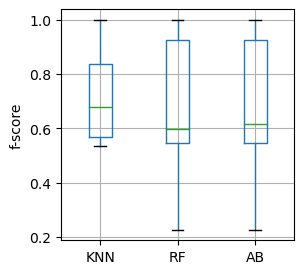

In [15]:
#boxplot of the results of the three models
ax = metrics.boxplot(figsize = (3,3))
ax.set_ylabel('f-score')
plt.show()

In [18]:
print(wilcoxon(metrics.KNN, metrics.RF))

WilcoxonResult(statistic=117480.0, pvalue=0.24425707217577175)


In [19]:
print(wilcoxon(metrics.KNN, metrics.AB))

WilcoxonResult(statistic=119782.0, pvalue=0.2921422599223621)


In [16]:
print(wilcoxon(metrics.RF, metrics.AB))

WilcoxonResult(statistic=35309.5, pvalue=0.010948366589202542)


In [17]:
print("Mean of RF: " + str(np.mean(metrics.RF)))
print("Mean of AB: " + str(np.mean(metrics.AB)))

Mean of RF: 0.7258121441113926
Mean of AB: 0.7355011494816601


---
__TREE ANALYSIS OF ADABOOST__

---

In [97]:
#creates a classifier that tries to predict the tester with the worst performances to see why

classifier_AdaBoost = AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators=61, min_samples_split=30, min_samples_leaf=1, max_features='sqrt', bootstrap=True, max_depth=10), n_estimators=83, random_state=0)
scaler = RobustScaler()
feat_sel = SelectKBest(k=2)

estimators_AdaBoost = [('scaling', scaler), ('feature-selection', feat_sel), ('clf', classifier_AdaBoost)]
pipe_AdaBoost_tree = Pipeline(estimators_AdaBoost)

X_train = ds[(ds['Tester'] != 'Lorenzo')].drop(columns=['Class', 'Tester'])
X_test= ds[(ds['Tester'] == 'Lorenzo')].drop(columns=['Class', 'Tester'])

y_train = ds[(ds['Tester'] != 'Lorenzo')]['Class']
y_test= ds[(ds['Tester'] == 'Lorenzo')]['Class']

pipe_AdaBoost_tree.fit(X_train, y_train)
y_pred = pipe_AdaBoost_tree.predict(X_test)

print(accuracy_score(y_pred, y_test))

#the selected k=2 best feature chosen by the model
print(X.columns[pipe_AdaBoost_tree['feature-selection'].get_support()])

0.5551470588235294
Index(['meanFreq_MaxS11', 'mean_S11DEG'], dtype='object')


In [98]:
#visulization of the tree rules
tree_to_code(pipe_AdaBoost_tree['clf'].estimators_[0].estimators_[31], X.columns[pipe_AdaBoost_tree['feature-selection'].get_support()])

def tree(meanFreq_MaxS11, mean_S11DEG):
  if mean_S11DEG <= 0.15322791039943695:
    if mean_S11DEG <= -0.7360658943653107:
      if meanFreq_MaxS11 <= -0.13573086261749268:
        return 1
      elif meanFreq_MaxS11 > -0.13573086261749268
        return 2
    elif mean_S11DEG > -0.7360658943653107
      if meanFreq_MaxS11 <= -0.0023201871663331985:
        return 1
      elif meanFreq_MaxS11 > -0.0023201871663331985
        if meanFreq_MaxS11 <= 0.7378190159797668:
          if meanFreq_MaxS11 <= 0.2238979060202837:
            return 0
          elif meanFreq_MaxS11 > 0.2238979060202837
            return 2
        elif meanFreq_MaxS11 > 0.7378190159797668
          return 1
  elif mean_S11DEG > 0.15322791039943695
    if meanFreq_MaxS11 <= 0.30510439816862345:
      return 0
    elif meanFreq_MaxS11 > 0.30510439816862345
      if meanFreq_MaxS11 <= 0.76450115442276:
        return 2
      elif meanFreq_MaxS11 > 0.76450115442276
        return 1


In [99]:
scaler.fit_transform(X_test[[X.columns[pipe_AdaBoost_tree['feature-selection'].get_support()][0], X.columns[pipe_AdaBoost_tree['feature-selection'].get_support()][1]]])

array([[-1.77462289e-01,  7.49998275e-01],
       [-1.77462289e-01,  7.48601878e-01],
       [-1.77462289e-01,  7.78356185e-01],
       [-1.77462289e-01,  7.58890797e-01],
       [-1.77462289e-01,  7.22943640e-01],
       [-1.77462289e-01,  7.77954480e-01],
       [-1.77462289e-01,  7.94110218e-01],
       [-1.77462289e-01,  7.79103209e-01],
       [-1.77462289e-01,  8.20745223e-01],
       [-1.77462289e-01,  8.79765368e-01],
       [-1.91659272e-01,  8.35172322e-01],
       [-2.17391304e-01,  6.00961266e-01],
       [-2.36024845e-01,  6.23702827e-01],
       [-2.60869565e-01,  4.13510976e-01],
       [-2.86601597e-01,  8.51589106e-02],
       [-2.98136646e-01, -2.12235555e-01],
       [-2.98136646e-01, -1.79989271e-01],
       [-3.07009760e-01, -5.70063641e-01],
       [-3.07897072e-01, -6.23379711e-01],
       [-3.07897072e-01, -6.13543607e-01],
       [-3.07897072e-01, -6.33459751e-01],
       [-3.07897072e-01, -6.35392593e-01],
       [-3.07897072e-01, -5.70614418e-01],
       [-3.

In [101]:
feature1 = X.columns[pipe_AdaBoost_tree['feature-selection'].get_support()][0]
feature2 = X.columns[pipe_AdaBoost_tree['feature-selection'].get_support()][1]
print(feature1)
print(feature2)

meanFreq_MaxS11
mean_S11DEG


In [102]:
feature1 = X.columns[pipe_AdaBoost_tree['feature-selection'].get_support()][0]
feature2 = X.columns[pipe_AdaBoost_tree['feature-selection'].get_support()][1]
tree_test = X_test[[feature1, feature2]]
tree_test_scaled = pd.DataFrame(scaler.fit_transform(tree_test))
print(tree_test_scaled)

            0         1
0   -0.177462  0.749998
1   -0.177462  0.748602
2   -0.177462  0.778356
3   -0.177462  0.758891
4   -0.177462  0.722944
..        ...       ...
267  0.692103 -0.812160
268  0.695652 -0.607696
269  0.704525 -0.008463
270  0.710736  0.403991
271  0.719610  1.011187

[272 rows x 2 columns]


In [105]:
y_pred_tree = pipe_AdaBoost_tree['clf'].estimators_[0].estimators_[31].predict(tree_test_scaled)
cm = confusion_matrix(y_test, y_pred_tree)

[[52 46  0]
 [55 13 27]
 [ 0  0 79]]


In [90]:
#scale the lorenzo dataset to confront it agaist the tree rules
columns = ds[(ds['Tester'] == 'Lorenzo')].drop(columns=['Class', 'Tester']).columns
class_col = ds[(ds['Tester'] == 'Lorenzo')]['Class']

scaled_lorenzo = pd.DataFrame(scaler.fit_transform(ds[(ds['Tester'] == 'Lorenzo')].drop(columns=['Class', 'Tester'])))
scaled_lorenzo.columns = columns
scaled_lorenzo['Class'] = class_col

C:\Users\Emanuele\AppData\Local\Temp\ipykernel_2840\1958947934.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('jet', len(unique))


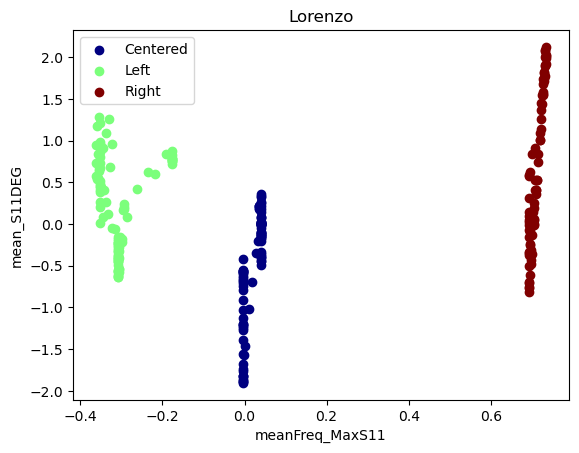

In [91]:
var1 = X.columns[pipe_AdaBoost['feature-selection'].get_support()][0]
var2 = X.columns[pipe_AdaBoost['feature-selection'].get_support()][1]

scatter_plot(scaled_lorenzo, var1, var2, 'Lorenzo')